In [20]:
import pde_control_gym 
import gymnasium as gym
import numpy as np
import math
import matplotlib.pyplot as plt
import time
# 加载一些工具
from utils import set_size
from utils import linestyle_tuple
from utils import load_csv
# use the stable_baselines3 
from stable_baselines3 import PPO
from stable_baselines3 import SAC
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import CheckpointCallback
# choose the pre-implemented reward function
from pde_control_gym.src import TunedReward1D
import os

In [21]:
# NO NOISE
# lambda state : state 输入状态值返回状态值
def noiseFunc(state):
    return state

# Chebyshev Polynomial Beta Functions
def solveBetaFunction(x, gamma):
    # 先创建一个数组 shape =（len(x),）
    beta = np.zeros(len(x), dtype=np.float32)
    # 遍历赋值
    for idx, val in enumerate(x):
        # 在每一个离散点上计算beta
        beta[idx] = 5 * math.cos(gamma * math.acos(val))
    return beta

# Returns beta functions passed into PDE environment. Currently gamma is always
# set to 7.35, but this can be modified for further problems.
# This function is used to create the beta function for the PDE environment.
def getBetaFunction(nx):
    return solveBetaFunction(np.linspace(0, 1, nx), 7.35)

# Kernel function solver for backstepping
def solveKernelFunction(beta):
    # theta 一个一维数组
    # 创建一个和 theta 一样长度的数组 kappa
    kappa = np.zeros(len(beta))
    # 索引从 0 到 len（theta）- 1，总的长度还是 len（theta）
    for i in range(0, len(beta)):
        kernelIntegral = 0
        # 矩形法离散积分函数值取左端点，所以只积分到 i-1 项
        for j in range(0, i):
            kernelIntegral += (kappa[i-j]*beta[j])*dx
        kappa[i] = kernelIntegral  - beta[i]
        # np.flip 用来翻转数组 （倒序 第一位为k（1））这样做是因为控制器是加权积分，（可以想象成卷积）因为状态是 u = [u(0), ····，u(1)]，对应的离散权重应该是 k =  [k(1), ····，u(0)]    
        # 则U(1,t) = np.sum(u * k) 按位相乘再相加
    return np.flip(kappa)

# Control convolution solver
def solveControl(kernel, u):
    res = 0
    for i in range(len(u)):
        res += kernel[i]*u[i]
    return res*dx

# Set initial condition function here
def getInitialCondition(nx):
    # *是按位乘法
    return np.ones(nx)*np.random.uniform(1, 10)


In [22]:
# Timestep and spatial step for PDE Solver
T = 5
# 0.0001
dt = 1e-4
X = 1
# 0.01
dx = 1e-2

In [23]:
# 定义奖励函数：设置时间步、提前截断的单位时间步惩罚、正常终止的奖励
reward_class =  TunedReward1D(int(round(T/dt)), -1e3, 3e2)

# 先设置一个通用的参数字典
hyperbolicParameters = {
        "T": T, 
        "dt": dt, 
        "X": X,
        "dx": dx, 
        "reward_class": reward_class,
        "normalize":None, 
        "sensing_loc": "full", 
        "control_type": "Dirchilet", 
        "sensing_type": None,
        # 确定传感器返回的测量值是否添加噪声，这里的这个表示精确的返回状态，并未添加任何噪声；（*lambda*构建了一个简单的函数，输入state，返回state）
        "sensing_noise_func": lambda state: state,
        # 用于早期停止的参数
        "limit_pde_state_size": True,
        "max_state_value": 1e10,
        "max_control_value": 20,
        # 传入初始条件的函数
        "reset_init_condition_func": getInitialCondition,
        # 传入计算beta的函数
        "reset_recirculation_func": getBetaFunction,
        # 控制采样频率 数值仿真时需要很小的时间步长，但控制器的接收控制信号无法这么快
        "control_sample_rate": 0.1,
}

# All of the 1D PDE boundary control environments have the same set of optional parameters for ease of use! 

# 通过浅拷贝的方式设置 Backstepping 方法参数字典
hyperbolicParametersBackstepping = hyperbolicParameters.copy()
# 在复制过来的通用基础上修改某些关键参数 ⬇️ Normalize 专为强化学习控制器设计，如果设置为True，则控制器的动作值会被归一化到[-1, 1]之间,并根据"max_control_value"转换为实际控制值
hyperbolicParametersBackstepping["normalize"] = False

# 设置 Rl 参数字典
hyperbolicParametersRL = hyperbolicParameters.copy()
# 需要用到线性化
hyperbolicParametersRL["normalize"] = True

In [113]:
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor

# 设置路径 （algo_name 和 run 需要更改）
algo_name = "SAC"
run = 2
run_id = f"{algo_name}_run{run}"
log_dir = f"./logs/{run_id}"
# print(run_id) 
# print(log_dir)
model_path = os.path.join(log_dir, "final_model.zip")
vecnorm_path = os.path.join(log_dir, "vecnormalize.pkl")

# =====创建环境=======
eval_envRL = DummyVecEnv([lambda: Monitor(gym.make("PDEControlGym-TransportPDE1D", **hyperbolicParametersRL))])
eval_envBS = DummyVecEnv([lambda: Monitor(gym.make("PDEControlGym-TransportPDE1D", **hyperbolicParametersBackstepping))])

# =====加载VecNormalize状态=====
eval_envRL = VecNormalize.load(vecnorm_path, eval_envRL)
eval_envRL.training = False     # 禁止在测试时更新统计量
eval_envRL.norm_reward = False  # 还原 reward 为原始量纲（如需要）

# ===加载模型===
model_class = {"PPO": PPO, "SAC": SAC}[algo_name]
model = model_class.load(model_path, env=eval_envRL, custom_objects={"learning_rate": 1e-4})

In [114]:
# Define Controllers
def bcksController(obs, beta):
    kernel = solveKernelFunction(beta)
    return solveControl(kernel, obs) # 通过函数返回的是控制输入

# wrapper function
def RLController(obs, model):
    action, _state = model.predict(obs)
    return action

def openLoopController(_, _a):
    return 0

In [115]:
def runSingleEpisode(controller, env, parameter):
    done = False
    uStorage = []

    # Reset Environment
    obs = env.reset()
    if isinstance(obs, tuple):
        obs = obs[0]
    obs = obs[0]  # 取出第一个环境的观测
    uStorage.append(obs)

    rew = 0
    while not done:
        action = controller(obs, parameter)
        obs, rewards, dones, infos = env.step([action])
        obs = obs[0]
        reward = rewards[0]
        done = dones[0]
        uStorage.append(obs)
        rew += reward
        # 如需判断是否 truncate，可用 is_truncated = infos[0].get("TimeLimit.truncated", False)
    u = np.array(uStorage)
    return rew, u

# 如果采用了 DummyVecEnv，无论你只用一个环境还是多个环境，所有与环境交互的输入和输出（obs、reward、done、info、action）都变成了“批量”格式，即：
# obs：是 shape = (num_envs, obs_dim) 的数组（即使 num_envs=1，也有一个外层维度）
# reward：是 shape = (num_envs,) 的数组
# done：是 shape = (num_envs,) 的数组
# info：是长度为 num_envs 的列表
# action：必须传 shape = (num_envs, ...) 的数组或列表
# 即使你只用了一个环境（num_envs=1），这些输入输出也都是“长度为1的向量/数组”。

In [116]:
# For backstepping controller
spatial = np.linspace(dx, X, int(round(X/dx)))
beta = solveBetaFunction(spatial, 7.35)

In [117]:
# # Run comparisons
# num_instances = 50
# # Backstepping. Controller is slow so this will take some time.
# total_bcks_reward = 0
# for i in range(num_instances):
#     rew, _ = runSingleEpisode(bcksController, eval_envBS, beta)
#     total_bcks_reward += rew
# print("Backstepping Reward Average:", total_bcks_reward/num_instances)

In [118]:
total_ppo_reward = 0
for i in range(50):
    rew, u = runSingleEpisode(RLController, eval_envRL, model)
    total_ppo_reward += rew
print("PPO Reward Average:", total_ppo_reward/50)

PPO Reward Average: 133.45226


In [119]:
rew, u = runSingleEpisode(RLController, eval_envRL, model)

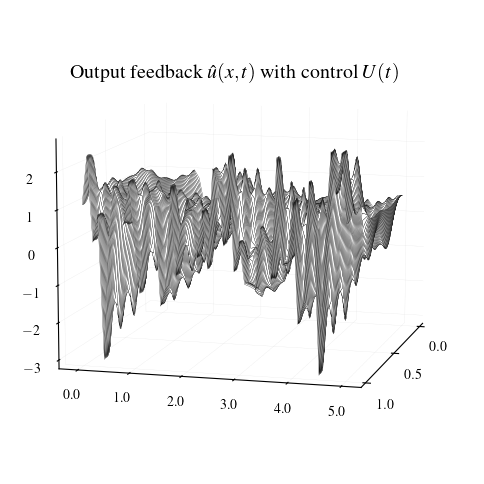

In [120]:
from matplotlib.ticker import FormatStrFormatter

# ✅ 创建图形
fig = plt.figure(figsize=set_size(522, 0.99, (1, 1)))
# fig.suptitle("openloop_contrast", fontsize=13, y=0.96)

# ✅ 左右两个子图组
subfigs = fig.subfigures(nrows=1, ncols=1)
subfigs.subplots_adjust(left=0.07, right=0.95, bottom=0.05, top=1.1)
subfigs.suptitle(r"Output feedback $\hat{u}(x, t)$ with control $U(t)$")

# ✅ 创建一个 3D 子图
ax = subfigs.subplots(1, 1, subplot_kw={"projection": "3d"})


for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "black"
    axis._axinfo['grid']['linewidth'] = 0.15
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d3d3d3"
    axis.set_pane_color((1, 1, 1))

# ✅ 加载数据
timearry = np.linspace(dt, T, len(u))
meshx, mesht = np.meshgrid(spatial, timearry)
uopen = u
# u_hat_open = Solver.u_hat

# ✅ 绘制曲面

ax.plot_surface(
        meshx, mesht, uopen,
        edgecolor="black", lw=0.2, rstride=50, cstride=1,
        alpha=1, color="white", shade=False, rasterized=True, antialiased=True
    )

ax.view_init(10, 15)
ax.zaxis.set_rotate_label(False)
ax.set_xticks([0, 0.5, 1])
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


# # 保存图片
# folder_path = os.path.expanduser("/Users/thy/Desktop/Work/Project/For-observer/Observer/result")  
# os.makedirs(folder_path, exist_ok=True)

# save_path = os.path.join(folder_path, r"Output feedback.pdf")
# plt.savefig(save_path, dpi=300, bbox_inches="tight")
# print(f"图像已保存到: {save_path}")

In [121]:
print(u.shape)

(51, 100)


In [122]:
# dx 是空间步长
l2_norm = np.sqrt(np.sum(u**2, axis=1) * dx)  # shape: (n_time,)

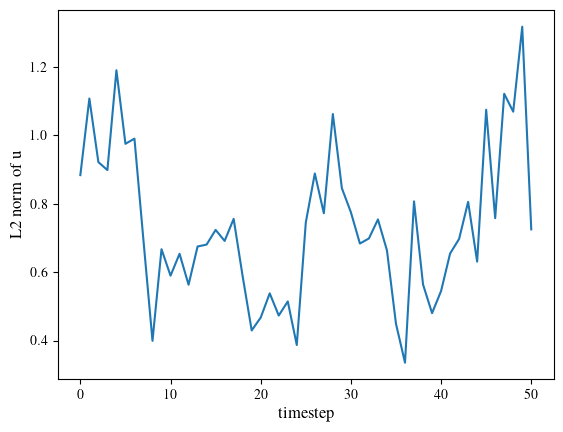

In [123]:
plt.plot(np.arange(len(l2_norm)), l2_norm)
plt.xlabel("timestep")
plt.ylabel("L2 norm of u")
plt.show()